In [6]:
import os
import sys
import matplotlib.pyplot as plt
import pickle 
# Modelling 
from sklearn.naive_bayes import BernoulliNB

import nltk 

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Metrics
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt


from nltk.corpus import stopwords


stop_words = set(stopwords.words("english"))
# Extend stopwords (see analysis below)
extension = {
    'trumps',
    'trump',
    'obama',
    'donald',
    'new',
    'u',
    'tramp'
}
stop_words.update(extension)
        
module_path = os.path.abspath(os.path.join('../../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
# Custom modules 
from modules import preprocessing as pp
from modules import graph


plt.style.use('ggplot')
np.random.seed(42)


from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [7]:
#import datat
df = pd.read_csv("../../src/data/df_one_plus_three.csv")

#inspect the first few rows
df.head(3)

,title,dataset,target
0,Bill Changing Credit Card Rules Is Sent to Oba...,1,0
1,"In Hollywood, the Easy-Money Generation Toughe...",1,0
2,1700 runners still unaccounted for in UK's Lak...,1,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51538 entries, 0 to 51537
Data columns (total 3 columns):
title      51538 non-null object
dataset    51538 non-null int64
target     51538 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


In [9]:
df.shape

(51538, 3)

# Make a validation dataset:


This dataframe is the combination of both `dataset 1` and `dataset 3` outlined in the README and created in `./notebooks/EDA/datasetCreation`. Currently, with minimal preprocessing and a simple Naive Bayes Classifier I was able to achieve an accuracy of 0.88 and an f1 of 0.87. My goal here is to improve that score by implementing some data cleaning steps prior to tokenization. Then, once I am convinced that my data prep steps are working, I will move onto implementing word imbeddings.

In [14]:
cleaned_headlines = [pp.clean_headlines(title) for title in df.title.to_list()]

In [12]:
df.title[0:20].to_list()

['Bill Changing Credit Card Rules Is Sent to Obama With Gun Measure Included',
 'In Hollywood, the Easy-Money Generation Toughens Up',
 "1700 runners still unaccounted for in UK's Lake District following flood",
 'Yankees Pitchers Trade Fielding Drills for Putting Practice',
 'Large earthquake rattles Indonesia; Seventh in two days',
 "Coldplay's new album hits stores worldwide this week",
 'U.N. Leader Presses Sri Lanka on Speeding Relief to War Refugees in Camps',
 '2 Somali-Americans Charged With Aiding Terror',
 "US Highway Administration releases interim report on Boston's Big Dig: press release claims tunnel safe, but report does not",
 'White House Announces International Meetings to Address Energy and Climate Issues',
 'With Troubled Coyotes, Gretzky Called On as Savior Again',
 'Door opens mid-Qantas flight; plane makes an emergency landing',
 'Gas prices surge in Northeast US',
 'Schapelle Corby found guilty, sentenced to 20 years',
 '2008 SecuTech Expo starts in Taipei, Taiw

In [ ]:
# Remove non_ascii characters
df['title_cleaned'] = df.title.apply(pp.remove_non_ascii_chars)
# Lowercase the words
df.title_cleaned = df.title_cleaned.apply(pp.lower_case)
# Remove contractions
df.title_cleaned = df.title_cleaned.apply(pp.remove_contractions)
# Remove stopwords
df.title_cleaned = df.title_cleaned.apply(remove_stopwords)
# Remove spelling mistakes 
df.title_cleaned = df.title_cleaned.apply(pp.fix_spelling_mistakes)

# Remove all punctuation
df.title_cleaned = df.title_cleaned.apply(pp.remove_punctuation)

In [68]:
# with open('spellcorrected2.pickle', 'wb') as f:
#     # Pickle the 'data' dictionary using the highest protocol available.
#     pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

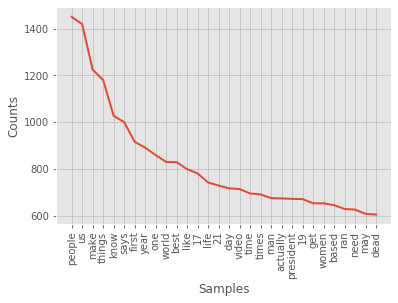

Current Vocab size is = 21373


In [69]:
title_cleaned = graph.get_vocab_length(df.title_cleaned)

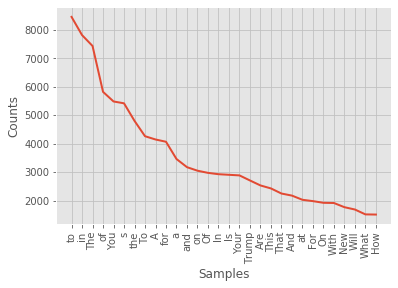

Current Vocab size is = 42185


In [70]:
title_dict= graph.get_vocab_length(df.title)

In [71]:
# Remove stopwords 
df.title_cleaned = df.title_cleaned.apply(pp.remove_stopwords)
df.title_cleaned

0        bill changing credit card rules sent gun measu...
1                  hollywood easy money generation touches
2        1700 runners still accounted lake district fol...
3        yankees pitcher trade yielding drills putting ...
4        large earthquake battles indonesia seventh two...
                               ...                        
51533    bc news video see brazil soccer team pilot fin...
51534                  politics scoop eric killed two deer
51535    french forest high school may delicate make wa...
51536    los angeles rams jeff fishes may think dandy w...
51537    seattle seahawks richard sherman says parma ca...
Name: title_cleaned, Length: 51538, dtype: object

In [72]:
def remove_stopwords(title):
    return " ".join([word.lower() for word in tokenizer.tokenize(title) if word.lower() not in stop_words])
df.title_cleaned = df.title_cleaned.apply(remove_stopwords)

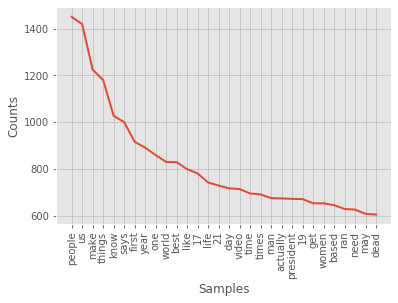

Current Vocab size is = 21243


In [73]:
title_cleaned = graph.get_vocab_length(df.title_cleaned)

In [74]:
df['title_cleaned_lem'] = df.title_cleaned.apply(pp.lemmetise_series)


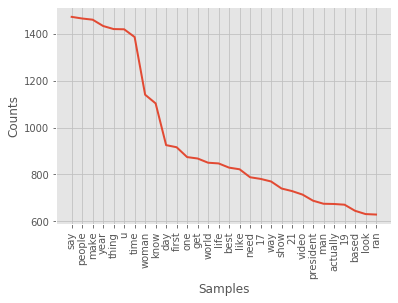

Current Vocab size is = 18898


In [75]:
title_cleaned_lem = graph.get_vocab_length(df.title_cleaned_lem)

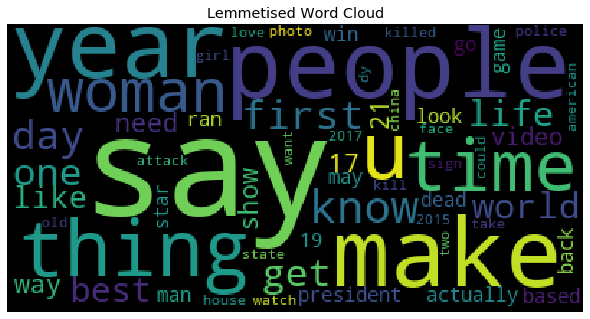

In [76]:
graph.show_wordcloud(title_cleaned_lem, title="Lemmetised Word Cloud")

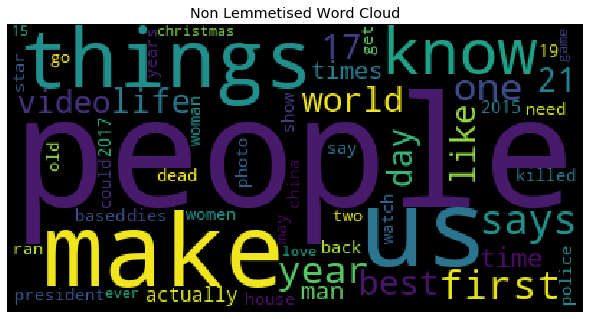

In [77]:
graph.show_wordcloud(title_cleaned, title="Non Lemmetised Word Cloud")

In [78]:

X = df.title_cleaned
y = df.target
X_train_lem, X_test_lem, y_train, y_test = train_test_split(X, y,
                                                            random_state=42, test_size=0.2,
                                                            stratify = df[['target', 'dataset']])

X_train_lem.shape, X_test_lem.shape, y_train.shape, y_test.shape

((41230,), (10308,), (41230,), (10308,))

In [79]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))
X_train_lem_tfidf = tfidf.fit_transform(X_train_lem)
X_test_lem_tfidf = tfidf.transform(X_test_lem)

In [80]:
bayes_clf = BernoulliNB(alpha = 0.4)

bayes_clf.fit(X_train_lem_tfidf, y_train)
y_hat_lem_train = bayes_clf.predict(X_train_lem_tfidf)
y_hat_lem_test = bayes_clf.predict(X_test_lem_tfidf)

accuracy_score(y_train, y_hat_lem_train), accuracy_score(y_test, y_hat_lem_test)

(0.9811059907834101, 0.8760186263096624)

# Ok, so spell checking everyword is probably not worth it. What if we do doc2vec?